# **EP1 - MAC0219**

## **Gustavo Santos Morais** - 11221932

## **Matheus Barbosa Silva** - 11221741

# **Preâmbulo**
Para a medição de tempo nos testes seguintes, foi utilizado o comando `time` com alterações nos programas principais.

**Configurações da máquina utilizada nos testes:** Sistema Operacional Debian 10.8, CPU Ryzen 7 3700U, 20GB de memória RAM.

In [14]:
import Pkg
using Pkg
Pkg.add("StatsPlots")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("CategoricalArrays")
using StatsPlots
using CSV
using DataFrames
using Statistics
using CategoricalArrays

# Mandelbrot - Sequencial

A análise do consumo de tempo do algoritmo sequencial para o cálculo do conjunto de Mandelbrot foi feita observando-se independentemente cada um dos seguintes aspectos:
- **Tamanho da saída:** dimensões da matriz tridimensional calculada para a região dada (correspondente às dimensões da imagem `output.ppm` gerada quando as operações de I/O estão habilitadas). Foram consideradas apenas saídas de altura e largura potências de 2 ($2^4,...,2^{13}$);
- **Regiões:** regiões do conjunto de Mandelbrot calculadas pelo algoritmo (_Elephant_, _Seahorse_, _Triple Spiral_ e _Full Picture_);
- **Uso das operações de I/O e Alocação de Memória**;
- **Variação do consumo de tempo**: comprimento do intervalo de confiança e distância do máximo e mínimo das medições em relação à mediana dos dados;

Para cada um dos cenários (**com** e **sem** I/O e alocação de memória para cada uma das regiões e tamanhos de saída) foram feitas dez medições do consumo de tempo do algoritmo e a partir desses dados foram gerados boxplots e gráficos de barra para as médias (com **intervalo de confiança de 95%**).

## Tamanho da Saída
Como esperado, este parâmetro foi o mais influente no aumento da quantidade de tempo usada pelo algoritmo. Nestes cenários, o consumo de tempo (nos casos com e sem I/O e alocação de memória) cresceu proporcionalmente ao tamanho da saída -- que, neste caso, aumentava **exponencialmente**.

Portanto, é possível observar (tanto no boxplot como no gráfico de médias) uma tendência exponencial no crescimento do consumo de tempo, seguindo o aumento do tamanho da saída.

## Regiões
Nota-se que cada uma das regiões dadas apresenta um comportamento próprio quanto ao consumo de tempo. Isto é, algumas regiões levam, naturalmente, mais tempo para que se possa convergir a um valor em cada ponto da imagem, enquanto outras (menos "detalhadas") convergem mais rapidamente.

Para as regiões _Elephant_, _Seahorse_ e _Triple Spiral_, o consumo de tempo é maior com relação à _Full Picture_ em todos os testes dado o maior nível de detalhamento necessário (com relação às cores da imagem gerada), com tempo que usualmente chegava a até 150s.

Já a região _Full Picture_ foi a que levou menos tempo para ser calculada em todos os testes, com tempo que usualmente não passava de 25s.

## Impacto das Operações de I/O e Alocação de Memória

Como esperado, o tempo despendido para a alocação de memória e operações de I/O é proporcional ao tamanho da saída.

Em média, o tempo de execução do algoritmo sem I/O e alocações de memória está abaixo do tempo médio gasto pelo mesmo algoritmo, mas com I/O e alocações de memória. Além disso, em todos os cenários o consumo de tempo mínimo ocorreu no caso sem I/O e alocações de memória.

Nota-se que o impacto do tamanho da saída é maior que o das operações de I/O e alocações de memória.

## Variação do consumo de tempo

Com a análise dos boxplots e intervalos de confiança dos gráficos de médias, fica claro que para maiores tamanhos de saída, há uma maior variação do consumo de tempo (perceptível pelo comprimento do intervalo de confiança e distância do máximo e mínimo dos dados com relação à mediana).

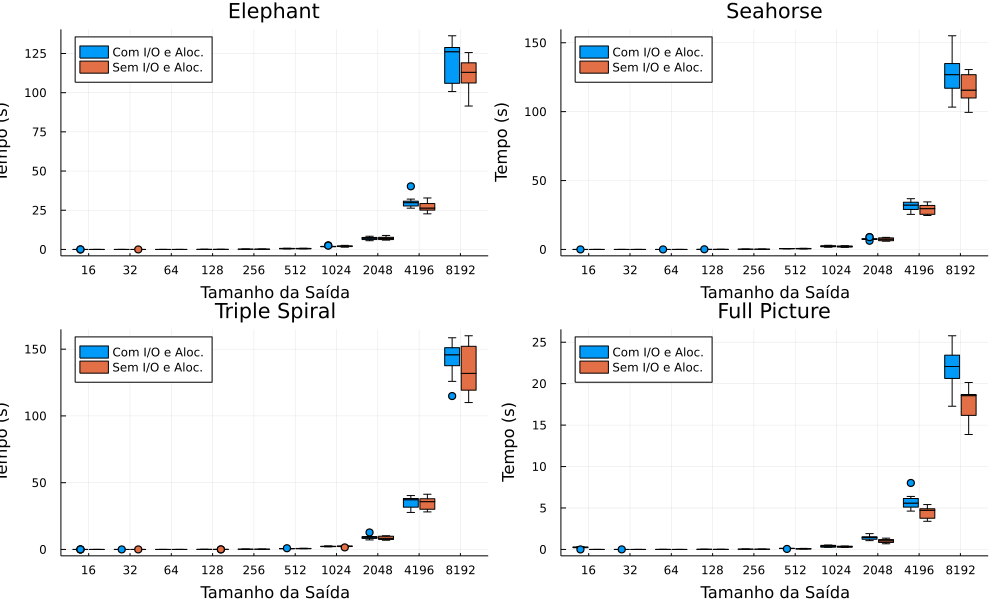

In [15]:
dataIoPaths = [ "../tests/seq/with-IO-Aloc/elephant.csv",
                "../tests/seq/with-IO-Aloc/seahorse.csv",
                "../tests/seq/with-IO-Aloc/triple_spiral.csv",
                "../tests/seq/with-IO-Aloc/full.csv"]
dataNoIoPaths = [ "../tests/seq/no-IO-Aloc/elephant.csv",
                "../tests/seq/no-IO-Aloc/seahorse.csv",
                "../tests/seq/no-IO-Aloc/triple_spiral.csv",
                "../tests/seq/no-IO-Aloc/full.csv"]
titles = ["Elephant" "Seahorse" "Triple Spiral" "Full Picture"]

xBoxplot = repeat(["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"], outer=20)
xBar = CategoricalArray(repeat(["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"], outer=2))
levels!(xBar, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
pBoxplot = []
pBar = []

for i in 1:4
    vBoxplot = []
    wBoxplot = []
    vBar = []
    wBar = []
    confint = []
    dataIO = CSV.read(dataIoPaths[i], DataFrame)
    dataNoIO = CSV.read(dataNoIoPaths[i], DataFrame)
    
    for row in eachrow(dataIO)
        vBoxplot = [vBoxplot;row."16";row."32";row."64";row."128";row."256";row."512";row."1024";row."2048";row."4196";row."8192"]
    end

    for column in eachcol(dataIO)
        a = mean(column)
        vBar = [vBar;a]
        push!(confint, 1.96*std(column)/sqrt(10))
    end

    for row in eachrow(dataNoIO)
        wBoxplot = [wBoxplot;row."16";row."32";row."64";row."128";row."256";row."512";row."1024";row."2048";row."4196";row."8192"]
    end

    for column in eachcol(dataNoIO)
        a = mean(column)
        wBar = [wBar;a]
        push!(confint, 1.96*std(column)/sqrt(10))
    end
    yBoxplot = [vBoxplot;vec(wBoxplot)]
    yBar = [vBar;vec(wBar)]
    yBar = convert(Array{Float64}, yBar)

    push!(pBoxplot, groupedboxplot(xBoxplot, yBoxplot, bar_width = 0.8,
                    group = repeat(["Com I/O e Aloc.", "Sem I/O e Aloc."], inner = 100),
                    xlabel = "Tamanho da Saída", ylabel="Tempo (s)", legend=:topleft))
    push!(pBar, groupedbar(xBar, yBar, yerr=confint,
                group = repeat(["Com I/O e Aloc.", "Sem I/O e Aloc."], inner = 10),
                xlabel = "Tamanho da Saída", ylabel="Tempo (s)", legend=:topleft))
end
plot(pBoxplot[1], pBoxplot[2], pBoxplot[3], pBoxplot[4], title = titles, layout = (2,2))
plot!(size=(1000,600))

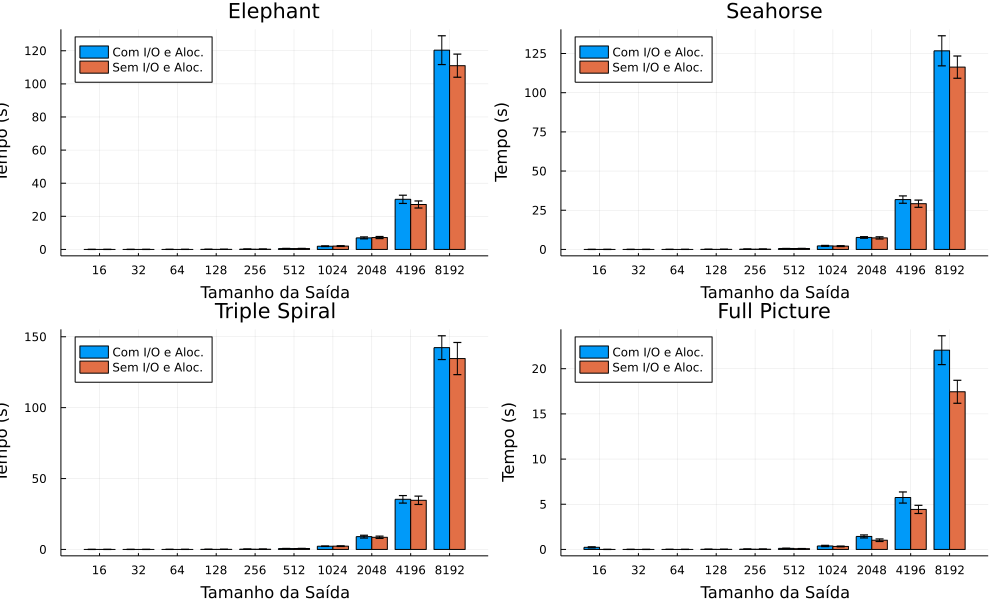

In [16]:
plot(pBar[1], pBar[2], pBar[3], pBar[4], title = titles, layout = (2,2))
plot!(size=(1000,600))

# Mandelbrot - Pthreads

A análise do consumo de tempo do algoritmo paralelo utilizando a biblioteca `Pthreads` para o cálculo do conjunto de Mandelbrot foi feita observando-se independentemente cada um dos seguintes aspectos:
- **Tamanho da saída:** dimensões da matriz tridimensional calculada para a região dada (correspondente às dimensões da imagem `output.ppm` gerada quando as operações de I/O estão habilitadas). Foram consideradas apenas saídas de altura e largura potências de 2 ($2^4,...,2^{13}$);
- **Regiões:** regiões do conjunto de Mandelbrot calculadas pelo algoritmo (_Elephant_, _Seahorse_, _Triple Spiral_ e _Full Picture_);
- **Número de threads:** número de threads utilizadas para dividir o trabalho feito pelo algoritmo. Foi considerado que o número de threads é potência de 2 ($2^0,...,2^5$);
- **Variação do consumo de tempo**: comprimento do intervalo de confiança e distância do máximo e mínimo das medições em relação à mediana dos dados;
- **Comparação com o algoritmo sequencial:** comparação do consumo de tempo do algoritmo paralelo usando `pthreads` com o sequencial.

Para cada um dos cenários (para todas as quantidades de threads, e cada uma das regiões e tamanhos de saída) foram feitas dez medições do consumo de tempo do algoritmo e a partir desses dados foram gerados boxplots e gráficos de barra para as médias (com **intervalo de confiança de 95%**).

**IMPORTANTE:** no cenário do tamanho de saída 16 com 32 threads, atribuiu-se um ponto da imagem a cada thread (totalizando 16 threads ocupadas) e foram criadas 16 threads adicionais que não executavam nenhum cálculo significante.

## Tamanho da Saída
Como esperado, este parâmetro foi o mais influente no aumento da quantidade de tempo usada pelo algoritmo. Nestes cenários, o consumo de tempo (para todas as quantidades de threads) cresceu proporcionalmente ao tamanho da saída -- que, neste caso, aumentava **exponencialmente**.

Portanto, é possível observar (tanto no boxplot como no gráfico de médias) uma tendência exponencial no crescimento do consumo de tempo, seguindo o aumento do tamanho da saída.

## Regiões
Nota-se que cada uma das regiões dadas apresenta um comportamento próprio quanto ao consumo de tempo. Isto é, algumas regiões levam, naturalmente, mais tempo para que se possa convergir a um valor em cada ponto da imagem, enquanto outras (menos "detalhadas") convergem mais rapidamente.

Para as regiões _Elephant_, _Seahorse_ e _Triple Spiral_, o consumo de tempo é maior com relação à _Full Picture_ em todos os testes dado o maior nível de detalhamento necessário (com relação às cores da imagem gerada), com tempo que usualmente chegava a até 250s.

Já a região _Full Picture_ foi a que levou menos tempo para ser calculada em todos os testes, com tempo que usualmente não passava de 50s.

## Número de threads

Em relação à quantidade de threads usada no algoritmo paralelo, percebe-se no geral uma melhora no desempenho conforme se aumenta essa quantidade para os casos das regiões _Elephant_, _Seahorse_ e _Triple Spiral_, mas para a região _Full Picture_, essa regra não se aplica. Na verdade, para essa região obteve-se o pior desempenho com 32 threads, e o melhor com 8 threads.

Isso mostra que quando utilizamos a biblioteca `Phreads`, aumentar o número de threads não implica diretamente na diminuição do consumo de tempo do algoritmo (ou seja, deve-se verificar de forma empírica qual é a quantidade ideal de threads para o algoritmo em questão).

## Variação do consumo de tempo

Com a análise dos boxplots e intervalos de confiança dos gráficos de médias, fica claro que para maiores tamanhos de saída e  para maior número de threads, há uma maior variação do consumo de tempo (perceptível pelo comprimento do intervalo de confiança e distância do máximo e mínimo dos dados com relação à mediana).

## Comparação com o algoritmo sequencial

Observando os dados obtidos para o algoritmo paralelo utilizando a biblioteca `Pthreads`, consegue-se perceber uma diminuição no consumo de tempo de até 66% em relação ao algoritmo sequencial. 

Isso deixa claro que o ganho de desempenho em relação ao algoritmo sequencial é significativamente grande.

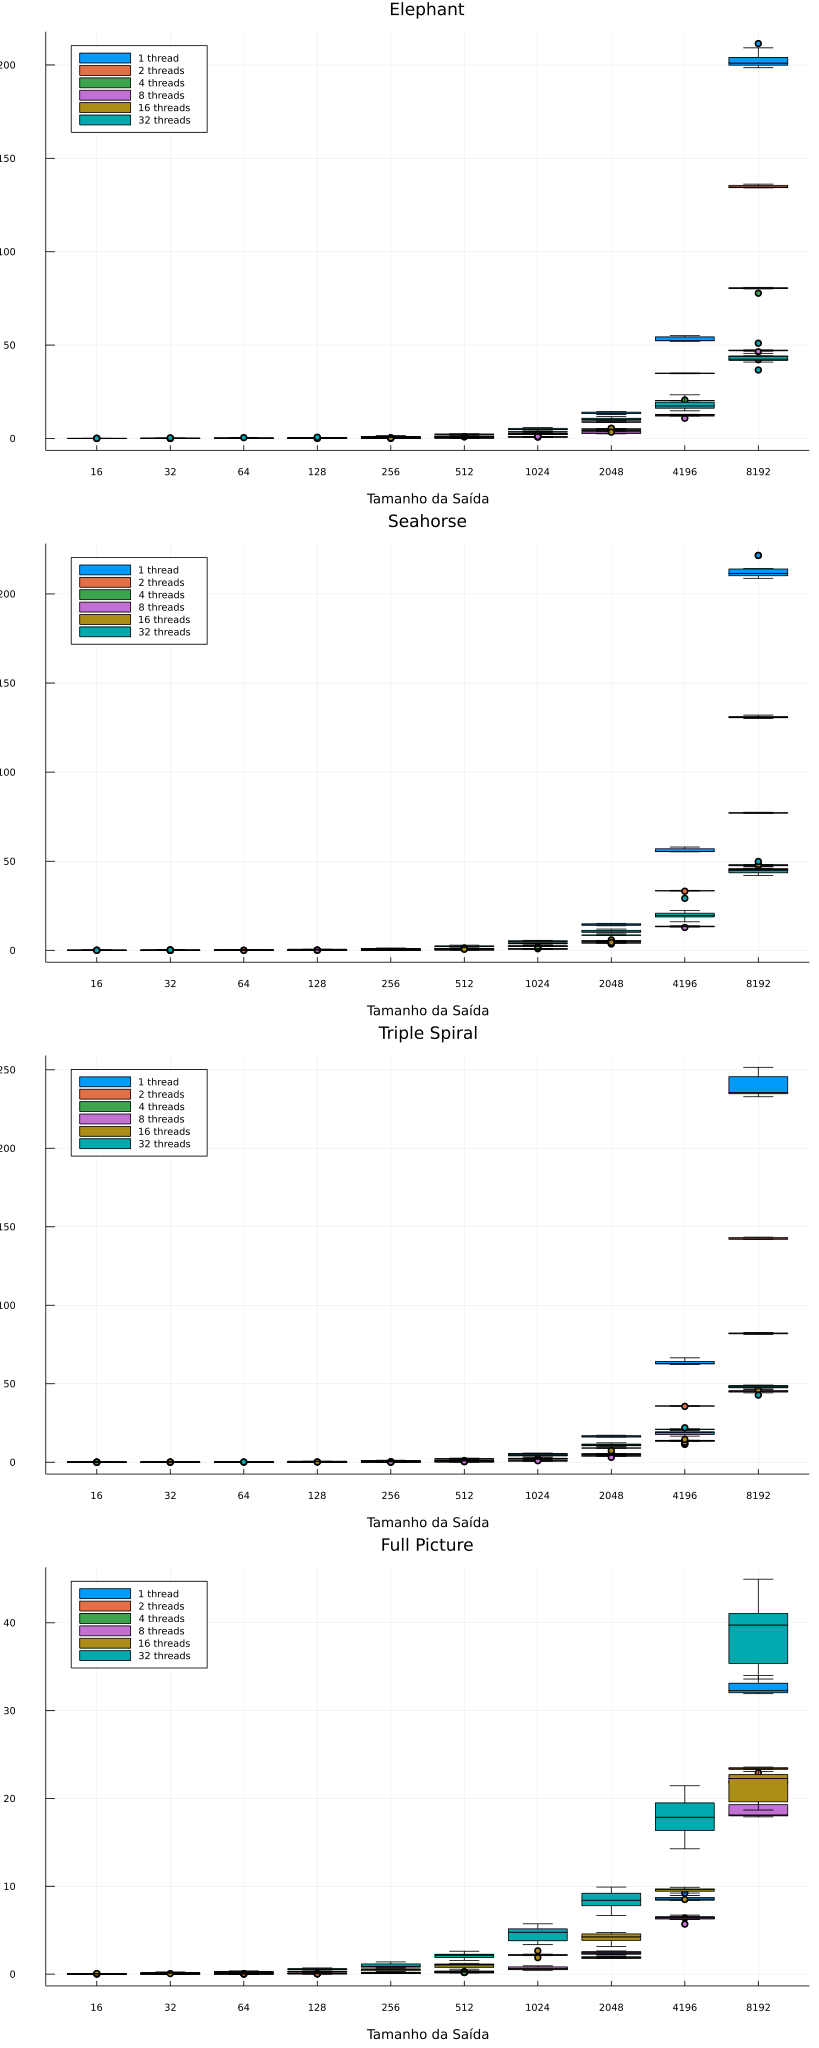

In [17]:
dataElephantPaths = [ "../tests/pth/elephant/elephant_1.csv",
                    "../tests/pth/elephant/elephant_2.csv",
                    "../tests/pth/elephant/elephant_4.csv",
                    "../tests/pth/elephant/elephant_8.csv",
                    "../tests/pth/elephant/elephant_16.csv",
                    "../tests/pth/elephant/elephant_32.csv"]

dataSeahorsePaths = [ "../tests/pth/seahorse/seahorse_1.csv",
                    "../tests/pth/seahorse/seahorse_2.csv",
                    "../tests/pth/seahorse/seahorse_4.csv",
                    "../tests/pth/seahorse/seahorse_8.csv",
                    "../tests/pth/seahorse/seahorse_16.csv",
                    "../tests/pth/seahorse/seahorse_32.csv"]

dataTSPaths = [ "../tests/pth/triple_spiral/triple_spiral_1.csv",
                "../tests/pth/triple_spiral/triple_spiral_2.csv",
                "../tests/pth/triple_spiral/triple_spiral_4.csv",
                "../tests/pth/triple_spiral/triple_spiral_8.csv",
                "../tests/pth/triple_spiral/triple_spiral_16.csv",
                "../tests/pth/triple_spiral/triple_spiral_32.csv"]

dataFullPaths = [ "../tests/pth/full/full_1.csv",
                "../tests/pth/full/full_2.csv",
                "../tests/pth/full/full_4.csv",
                "../tests/pth/full/full_8.csv",
                "../tests/pth/full/full_16.csv",
                "../tests/pth/full/full_32.csv"]

titles = ["Elephant" "Seahorse" "Triple Spiral" "Full Picture"]
dataPaths = [dataElephantPaths, dataSeahorsePaths, dataTSPaths, dataFullPaths]

titles = ["Elephant" "Seahorse" "Triple Spiral" "Full Picture"]
dataPaths = [dataElephantPaths, dataSeahorsePaths, dataTSPaths, dataFullPaths]

x = CategoricalArray(["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
levels!(x, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
legends = ["1 thread", "2 threads", "4 threads", "8 threads", "16 threads", "32 threads"]
p = []

for j in 1:4
    boxplotRegion = plot()
    for i in 1:6
        v = []
        w = []
        confint = []
        data = CSV.read(dataPaths[j][i], DataFrame)

        for row in eachrow(data)
            v = [v;row."16";row."32";row."64";row."128";row."256";row."512";row."1024";row."2048";row."4196";row."8192"]
        end

        for column in eachcol(data)
            a = mean(column)
            w = [w;a]
            push!(confint, 1.96*std(column)/sqrt(10))
        end

        boxplotRegion = groupedboxplot!(x, vec(v), bar_width = 0.8, xlabel = "Tamanho da Saída", ylabel="Tempo (s)", legend=:topleft, label=legends[i])
    end
    push!(p, boxplotRegion)
end

plot(p[1], p[2], p[3], p[4], title = titles, layout = (4,1))
plot!(size=(1000,2500))

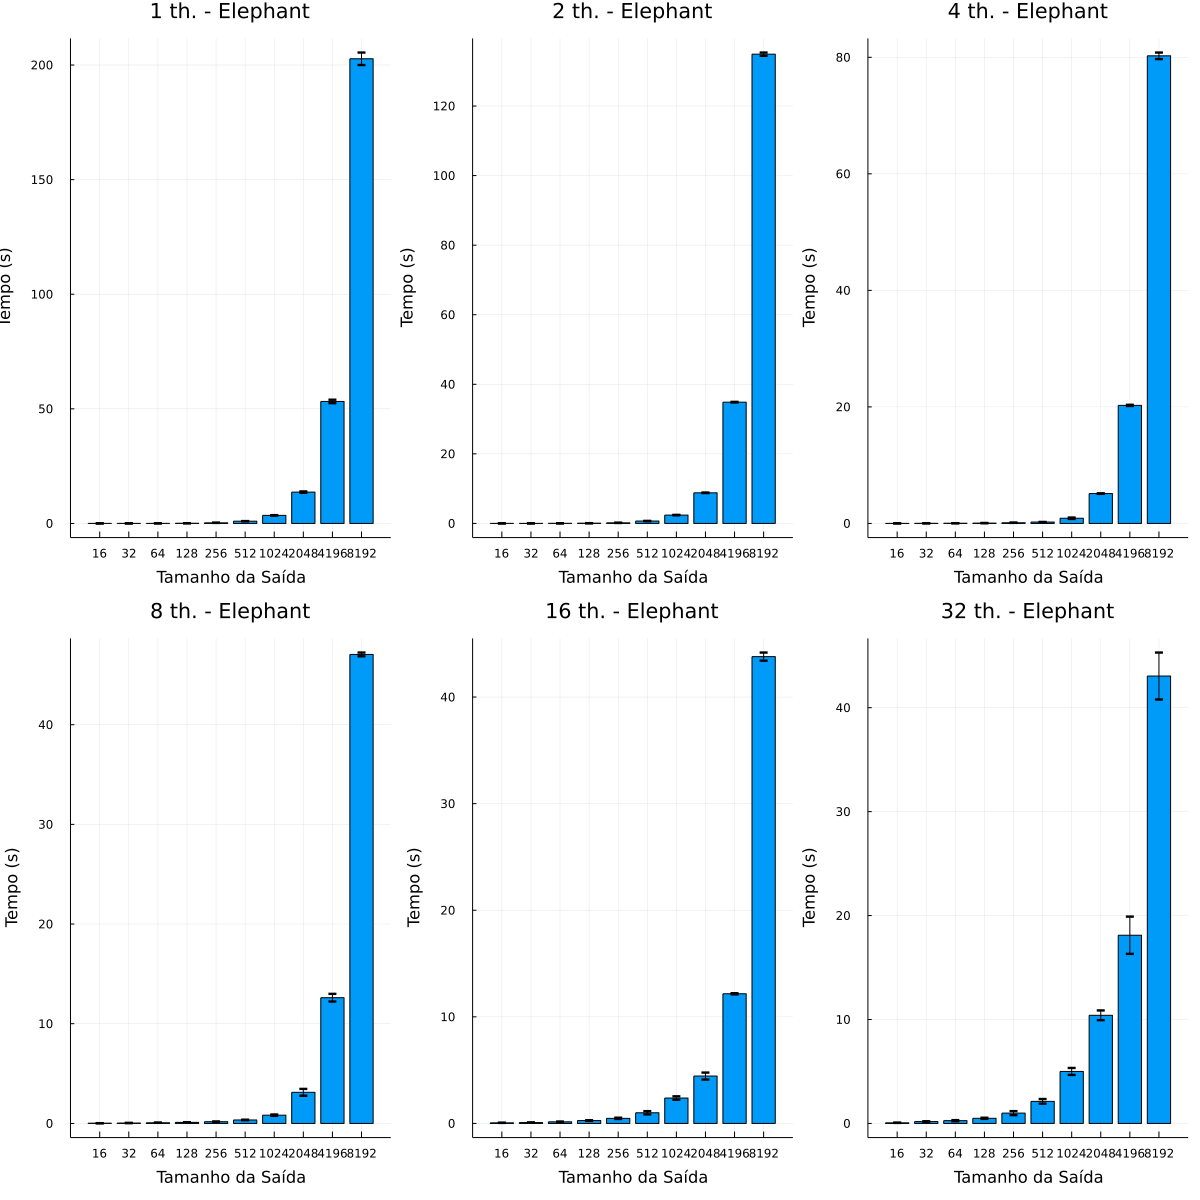

In [18]:
p = []
x = CategoricalArray(["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
levels!(x, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
xticksBar = (1:10, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])

for j in 1:4
    for i in 1:6
        v = []
        confint = []
        data = CSV.read(dataPaths[j][i], DataFrame)

        for column in eachcol(data)
            a = mean(column)
            v = [v;a]
            push!(confint, 1.96*std(column)/sqrt(10))
        end

        push!(p, bar(x, v, yerr=confint, xticks=xticksBar, legend=false,
              xlabel="Tamanho da Saída", ylabel="Tempo (s)"))
    end
end

legends = ["1 th." "2 th." "4 th." "8 th." "16 th." "32 th."]
barTitles = legends .* " - Elephant"
plot(p[1], p[2], p[3], p[4], p[5], p[6],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

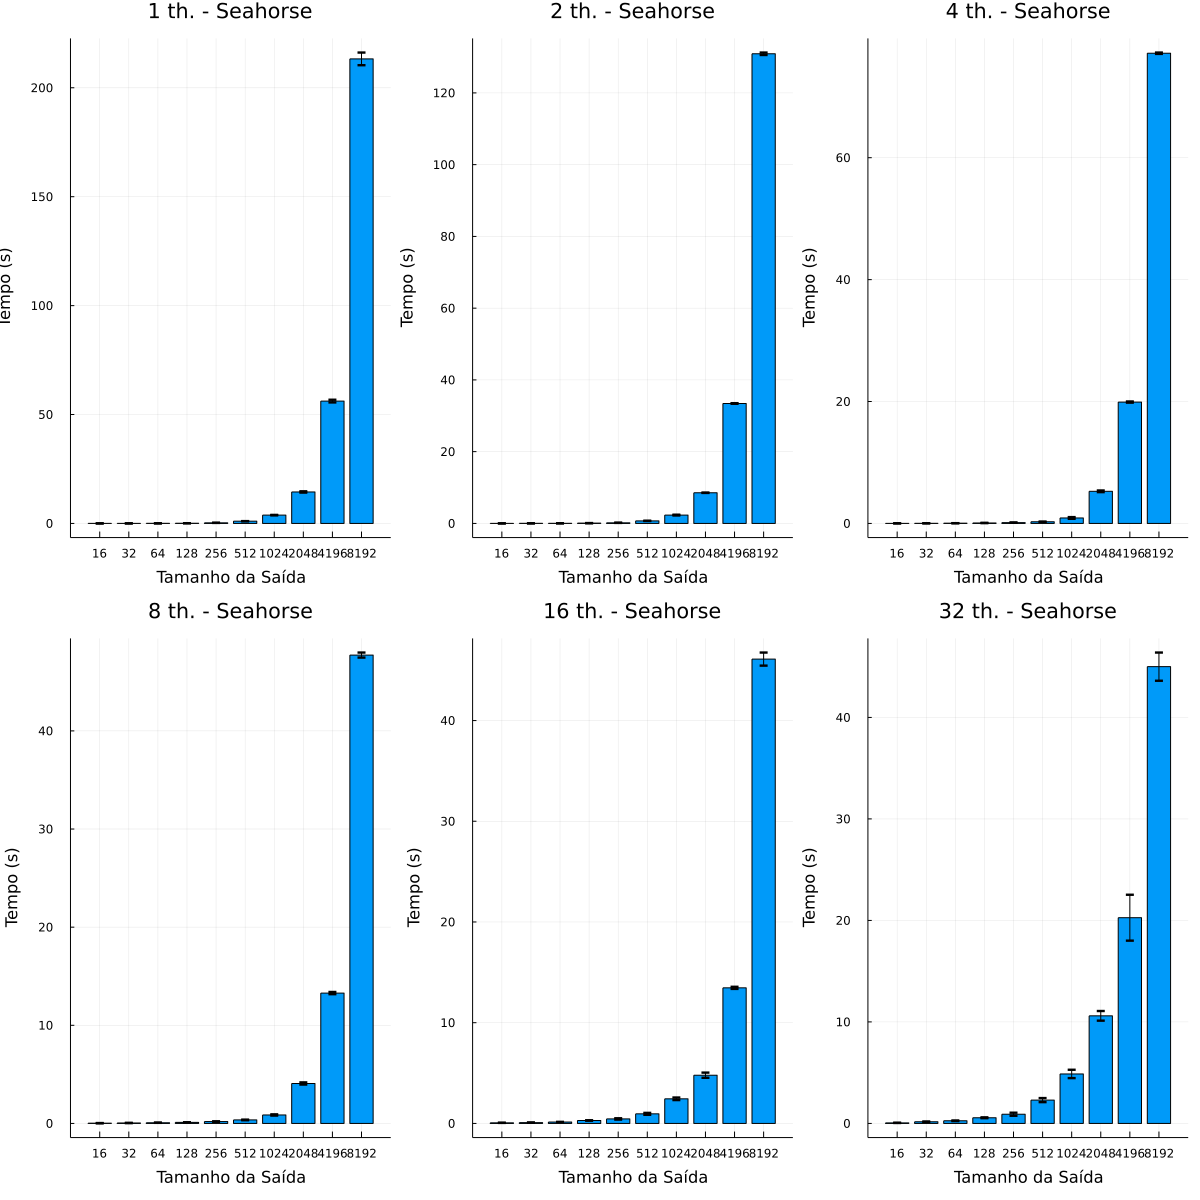

In [19]:
barTitles = legends .* " - Seahorse"
plot(p[7], p[8], p[9], p[10], p[11], p[12],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

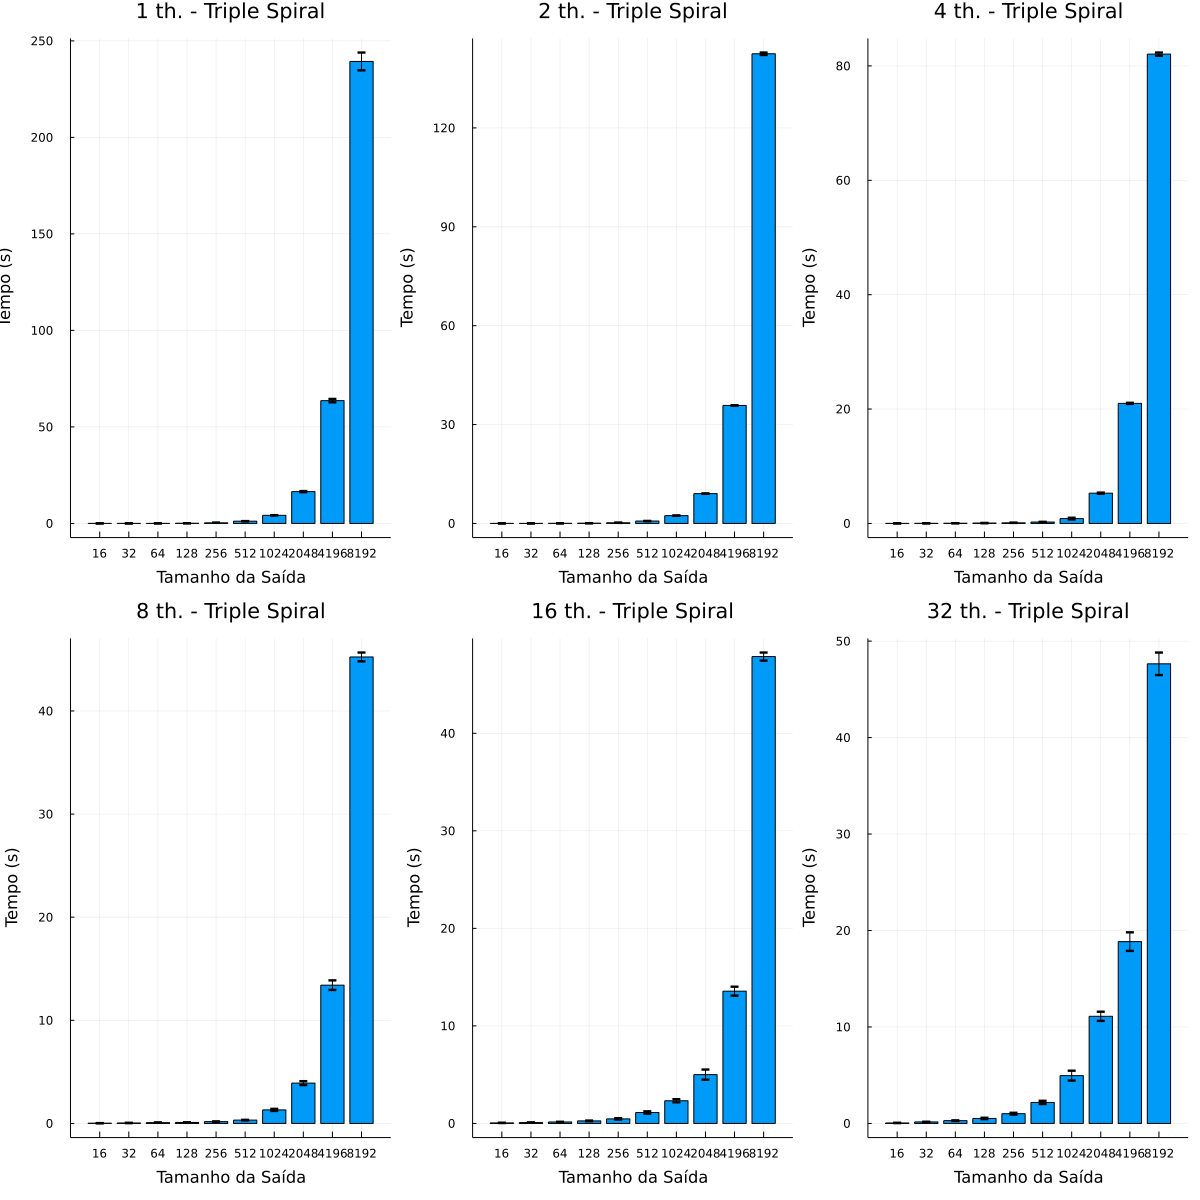

In [20]:
barTitles = legends .* " - Triple Spiral"
plot(p[13], p[14], p[15], p[16], p[17], p[18],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

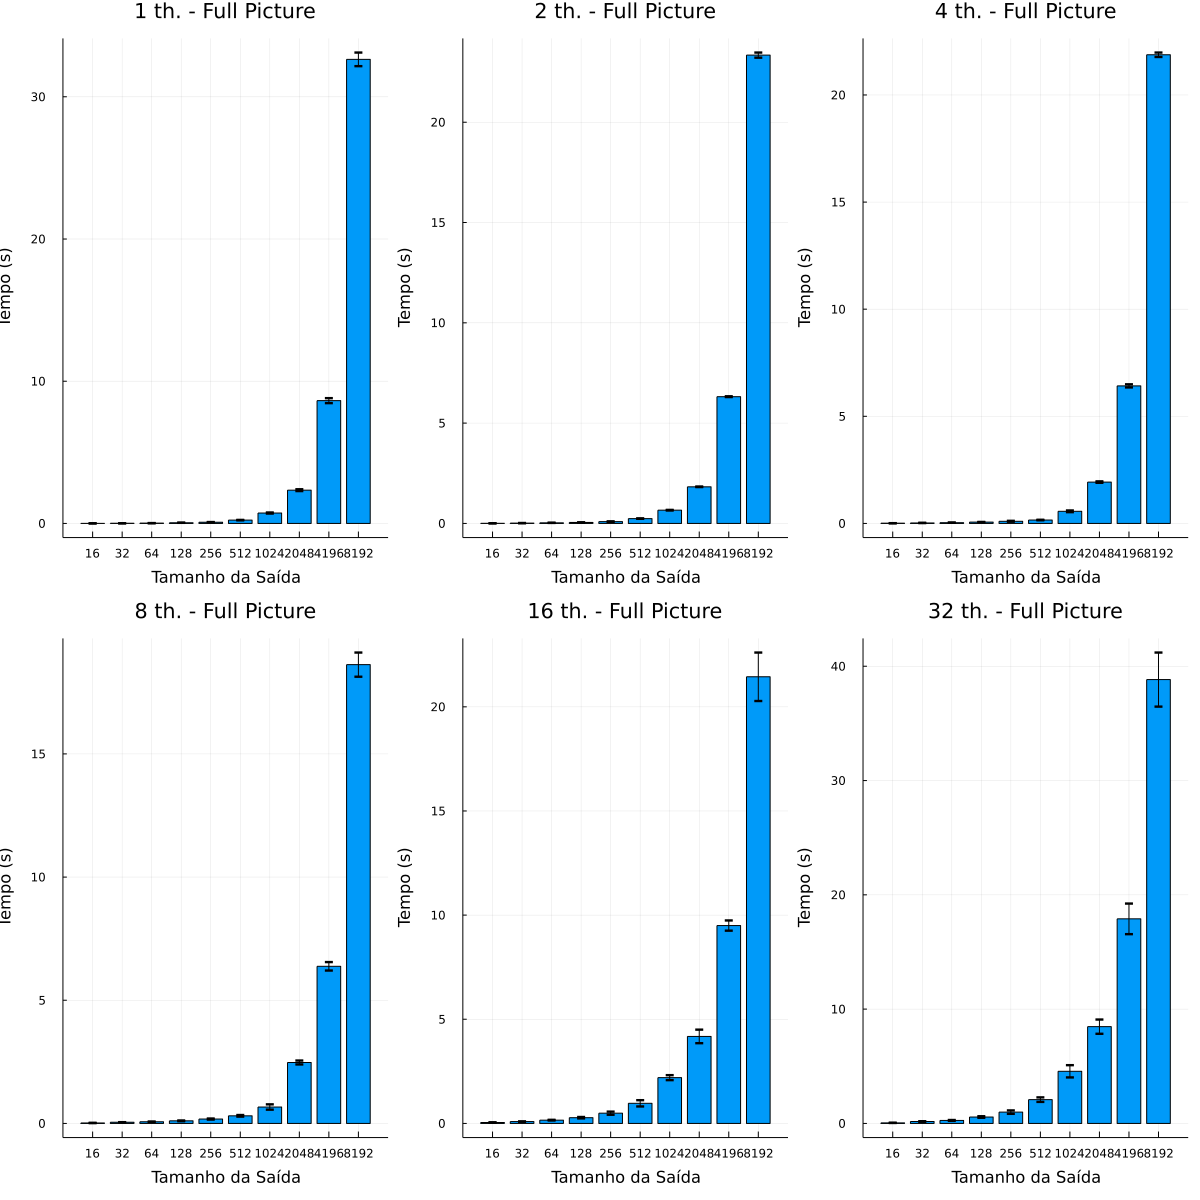

In [21]:
barTitles = legends .* " - Full Picture"
plot(p[19], p[20], p[21], p[22], p[23], p[24],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

# Mandelbrot - OpenMP

A análise do consumo de tempo do algoritmo paralelo utilizando a biblioteca `omp` (`OpenMP`) para o cálculo do conjunto de Mandelbrot foi feita observando-se independentemente cada um dos seguintes aspectos:
- **Tamanho da saída:** dimensões da matriz tridimensional calculada para a região dada (correspondente às dimensões da imagem `output.ppm` gerada quando as operações de I/O estão habilitadas). Foram consideradas apenas saídas de altura e largura potências de 2 ($2^4,...,2^{13}$);
- **Regiões:** regiões do conjunto de Mandelbrot calculadas pelo algoritmo (_Elephant_, _Seahorse_, _Triple Spiral_ e _Full Picture_);
- **Número de threads:** número de threads utilizadas para dividir o trabalho feito pelo algoritmo. Foi considerado que o número de threads é potência de 2 ($2^0,...,2^5$) e foi feita uma adaptação no algoritmo para que este também passasse a receber como entrada o número de threads;
- **Variação do consumo de tempo**: comprimento do intervalo de confiança e distância do máximo e mínimo das medições em relação à mediana dos dados;
- **Comparação com o algoritmo sequencial:** comparação do consumo de tempo do algoritmo paralelo usando `OpenMP` com o sequencial.

Para cada um dos cenários (para todas as quantidades de threads, e cada uma das regiões e tamanhos de saída) foram feitas dez medições do consumo de tempo do algoritmo e a partir desses dados foram gerados boxplots e gráficos de barra para as médias (com **intervalo de confiança de 95%**).

**IMPORTANTE:** no cenário do tamanho de saída 16 com 32 threads, considerou-se o tempo gasto como 0 dado que não seria possível criar e executar as 32 threads simultaneamente e, ainda assim, manter o algoritmo correto, funcional e, sobretudo, sem desvios do objetivo principal.

## Tamanho da Saída
Como esperado, assim como no algoritmo sequencial e com `Pthreads`, este parâmetro foi o mais influente no aumento da quantidade de tempo usada pelo algoritmo. Nestes cenários, o consumo de tempo (para todas as quantidades de threads) cresceu proporcionalmente ao tamanho da saída -- que, neste caso, aumentava **exponencialmente**.

Portanto, também usando o `OpenMP` é possível observar (tanto no boxplot como no gráfico de médias) uma tendência exponencial no crescimento do consumo de tempo, seguindo o aumento do tamanho da saída.

## Regiões
Assim como nos outros dois algoritmos, nota-se aqui que cada uma das regiões dadas apresenta um comportamento próprio quanto ao consumo de tempo. Isto é, algumas regiões levam, naturalmente, mais tempo para que se possa convergir a um valor em cada ponto da imagem, enquanto outras (menos "detalhadas") convergem mais rapidamente.

Para as regiões _Elephant_, _Seahorse_ e _Triple Spiral_, o consumo de tempo é maior com relação à _Full Picture_ em todos os testes dado o maior nível de detalhamento necessário (com relação às cores da imagem gerada), com tempo que usualmente chegava a até 140s.

Já a região _Full Picture_ foi a que levou menos tempo para ser calculada em todos os testes, com tempo que usualmente não passava de 3s na execução com 32 threads (melhores resultados).

## Número de threads

Em relação à quantidade de threads usada no algoritmo paralelo, nota-se uma consistente melhoria no desempenho do algoritmo para maiores números de threads na execução do algoritmo para todas as regiões.

Como esperado, maiores quantidades de threads não apresentam bom desempenho para tamanhos de saída menores.

Ainda assim, isso não significa que esta característica (melhoria de desempenho) se estenda continuamente para maiores números de threads. De fato, parece haver uma limitação para essa diminuição do consumo de tempo (o que se demonstra pelas diminuições menos expressivas entre os números de threads maiores).

## Variação do consumo de tempo

Com a análise dos boxplots e intervalos de confiança dos gráficos de médias, fica claro que para maiores tamanhos de saída e  para maior número de threads, há uma maior variação do consumo de tempo (perceptível pelo comprimento do intervalo de confiança e distância do máximo e mínimo dos dados com relação à mediana).

## Comparação com o algoritmo sequencial

Observando os dados obtidos para o algoritmo paralelo utilizando a biblioteca `omp`, nota-se uma diminuição no consumo de tempo de até 90% em relação ao algoritmo sequencial. 

Isso deixa claro que o ganho de desempenho em relação ao algoritmo sequencial é significativamente grande -- e ainda maior que o ganho de desempenho com a biblioteca `Pthreads`.

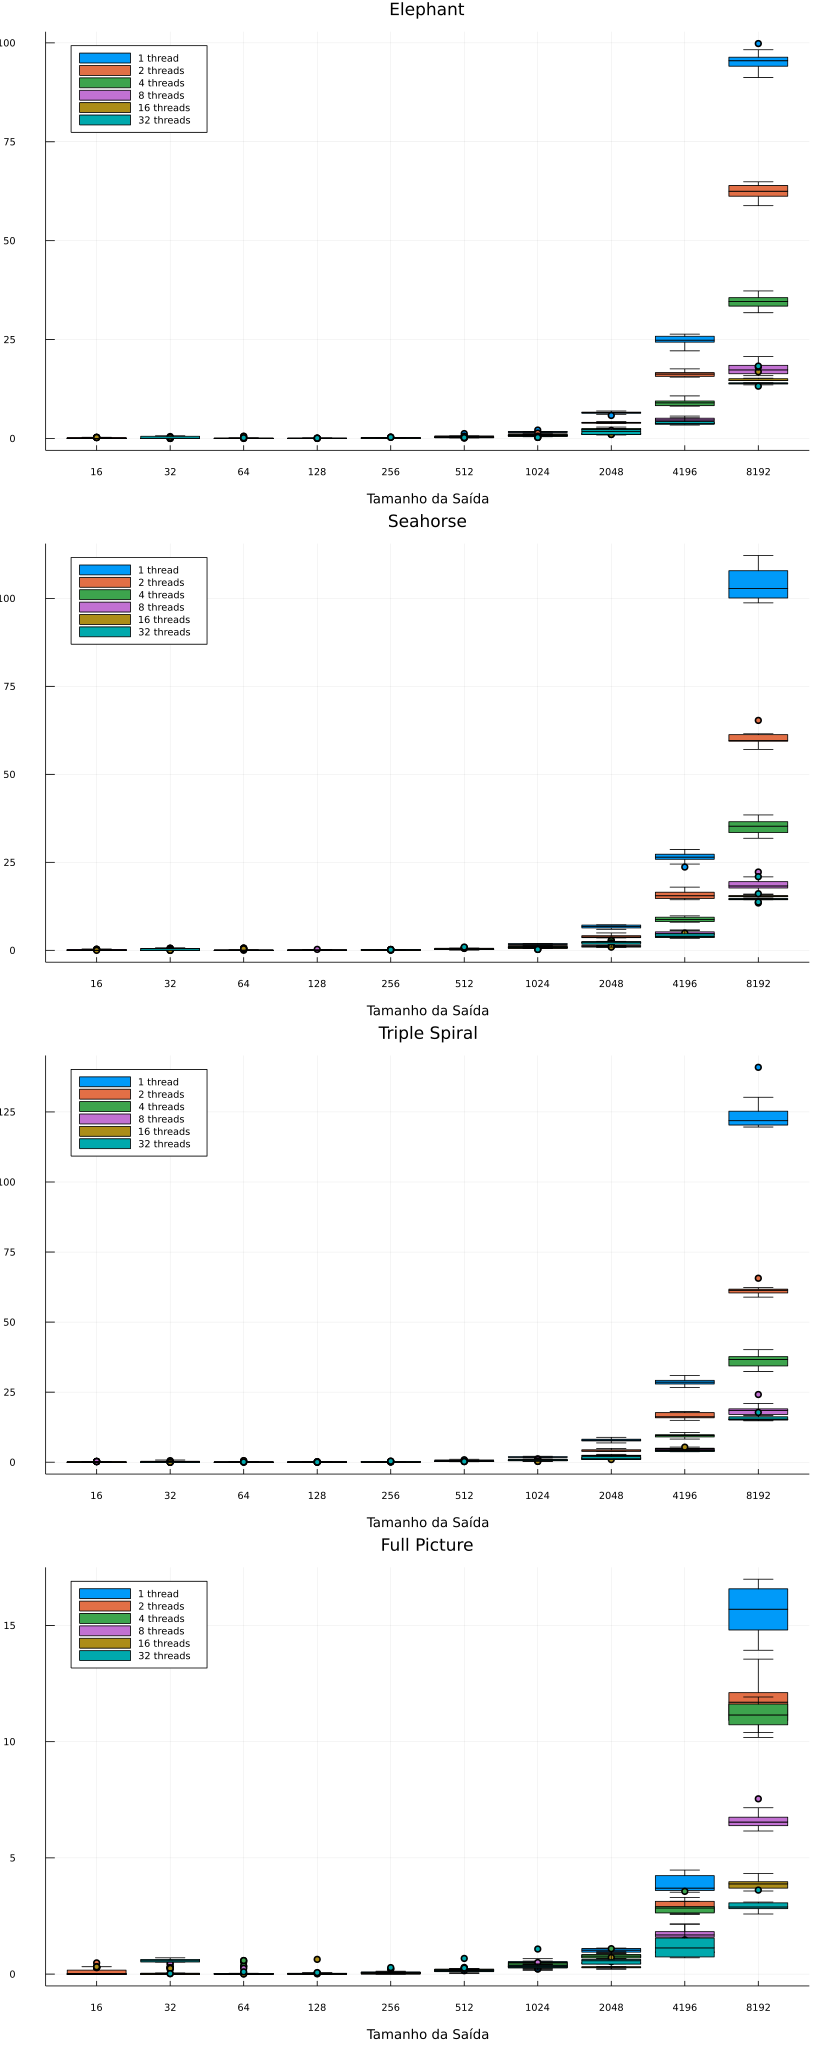

In [22]:
dataElephantPaths = [ "../tests/omp/elephant/elephant_1.csv",
                    "../tests/omp/elephant/elephant_2.csv",
                    "../tests/omp/elephant/elephant_4.csv",
                    "../tests/omp/elephant/elephant_8.csv",
                    "../tests/omp/elephant/elephant_16.csv",
                    "../tests/omp/elephant/elephant_32.csv"]

dataSeahorsePaths = [ "../tests/omp/seahorse/seahorse_1.csv",
                    "../tests/omp/seahorse/seahorse_2.csv",
                    "../tests/omp/seahorse/seahorse_4.csv",
                    "../tests/omp/seahorse/seahorse_8.csv",
                    "../tests/omp/seahorse/seahorse_16.csv",
                    "../tests/omp/seahorse/seahorse_32.csv"]

dataTSPaths = [ "../tests/omp/triple_spiral/triple_spiral_1.csv",
                "../tests/omp/triple_spiral/triple_spiral_2.csv",
                "../tests/omp/triple_spiral/triple_spiral_4.csv",
                "../tests/omp/triple_spiral/triple_spiral_8.csv",
                "../tests/omp/triple_spiral/triple_spiral_16.csv",
                "../tests/omp/triple_spiral/triple_spiral_32.csv"]

dataFullPaths = [ "../tests/omp/full/full_1.csv",
                "../tests/omp/full/full_2.csv",
                "../tests/omp/full/full_4.csv",
                "../tests/omp/full/full_8.csv",
                "../tests/omp/full/full_16.csv",
                "../tests/omp/full/full_32.csv" ]

titles = ["Elephant" "Seahorse" "Triple Spiral" "Full Picture"]
dataPaths = [dataElephantPaths, dataSeahorsePaths, dataTSPaths, dataFullPaths]

x = CategoricalArray(["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
levels!(x, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
legends = ["1 thread", "2 threads", "4 threads", "8 threads", "16 threads", "32 threads"]
p = []

for j in 1:4
    boxplotRegion = plot()
    for i in 1:6
        v = []
        w = []
        confint = []
        data = CSV.read(dataPaths[j][i], DataFrame)

        for row in eachrow(data)
            v = [v;row."16";row."32";row."64";row."128";row."256";row."512";row."1024";row."2048";row."4196";row."8192"]
        end

        for column in eachcol(data)
            a = mean(column)
            w = [w;a]
            push!(confint, 1.96*std(column)/sqrt(10))
        end

        boxplotRegion = groupedboxplot!(x, vec(v), bar_width = 0.8, xlabel = "Tamanho da Saída", ylabel="Tempo (s)", legend=:topleft, label=legends[i])
    end
    push!(p, boxplotRegion)
end

plot(p[1], p[2], p[3], p[4], title = titles, layout = (4,1))
plot!(size=(1000,2500))

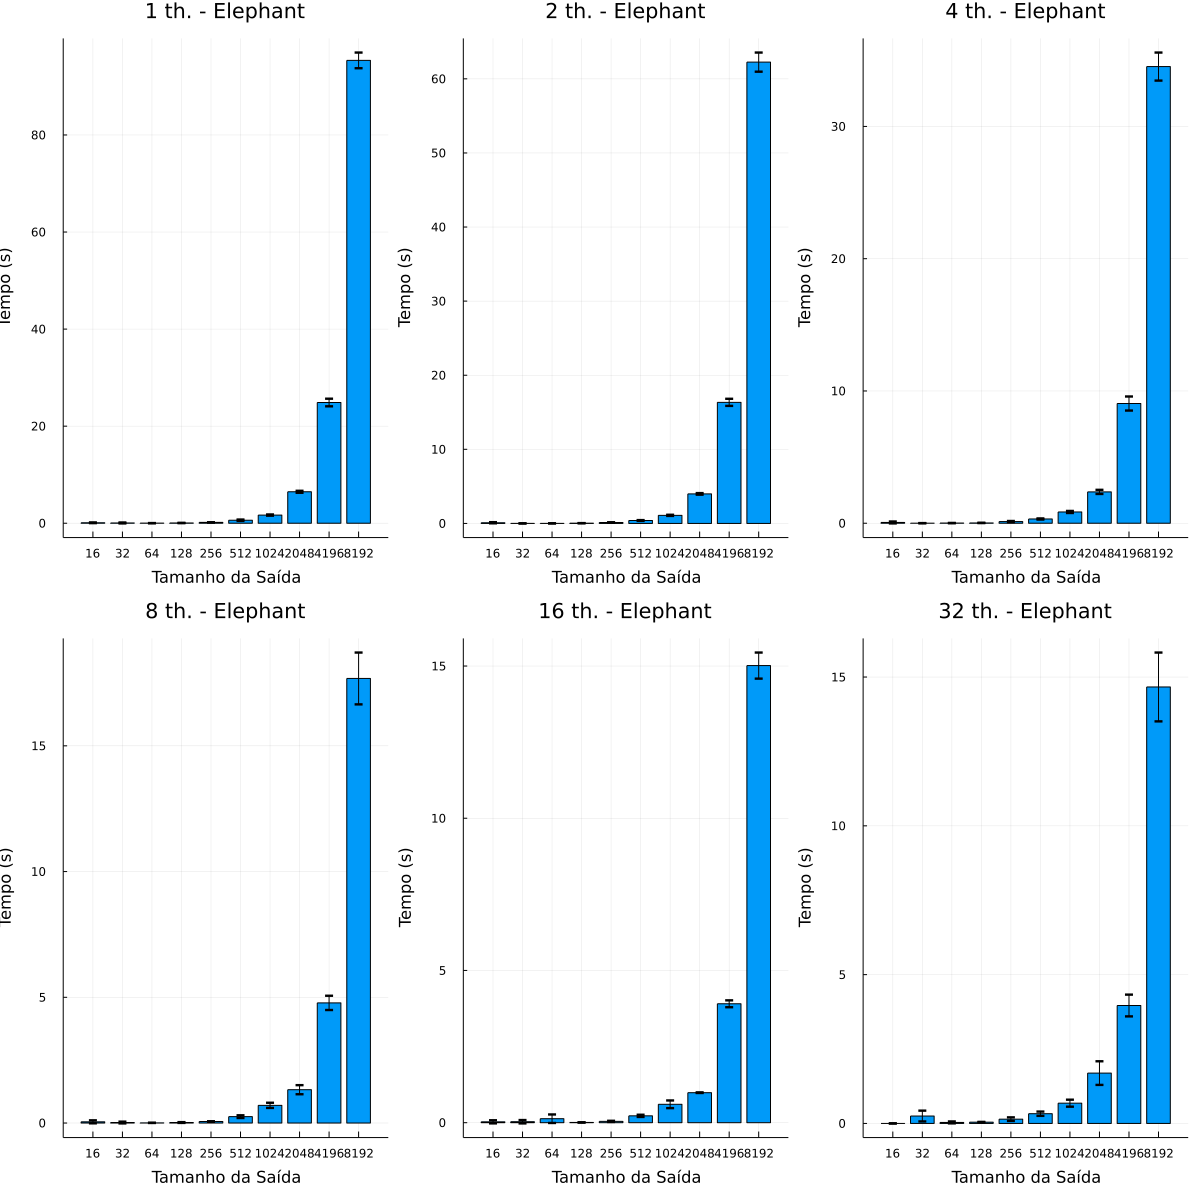

In [23]:
p = []
x = CategoricalArray(["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
levels!(x, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])
xticksBar = (1:10, ["16", "32", "64", "128", "256", "512", "1024", "2048", "4196", "8192"])

for j in 1:4
    for i in 1:6
        v = []
        confint = []
        data = CSV.read(dataPaths[j][i], DataFrame)

        for column in eachcol(data)
            a = mean(column)
            v = [v;a]
            push!(confint, 1.96*std(column)/sqrt(10))
        end

        push!(p, bar(x, v, yerr=confint, xticks=xticksBar, legend=false,
              xlabel="Tamanho da Saída", ylabel="Tempo (s)"))
    end
end

legends = ["1 th." "2 th." "4 th." "8 th." "16 th." "32 th."]
barTitles = legends .* " - Elephant"
plot(p[1], p[2], p[3], p[4], p[5], p[6],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

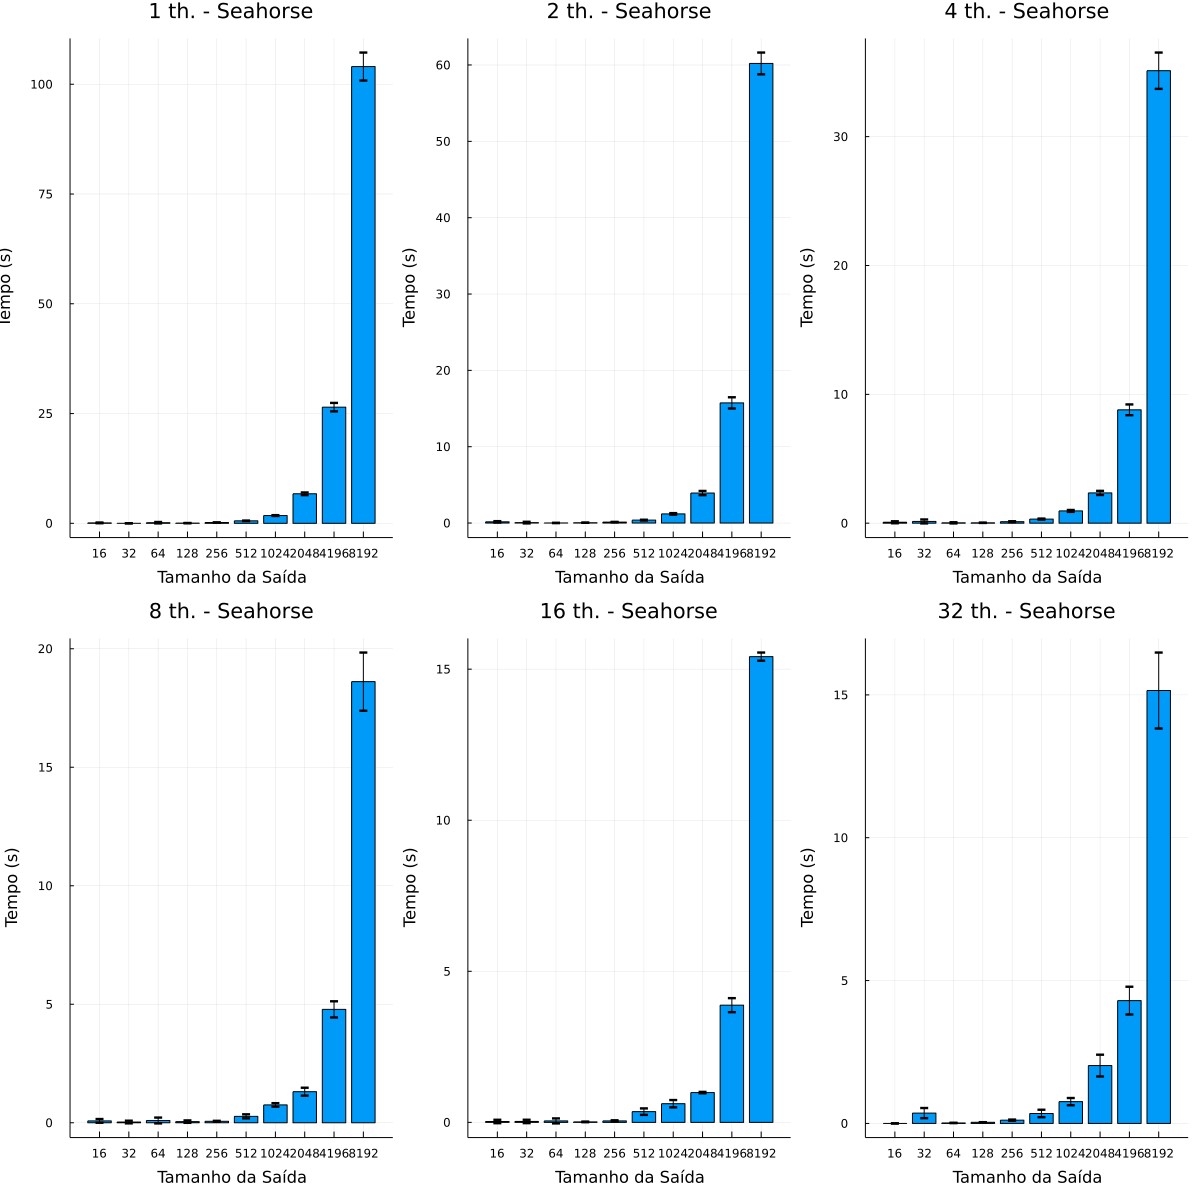

In [24]:
barTitles = legends .* " - Seahorse"
plot(p[7], p[8], p[9], p[10], p[11], p[12],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

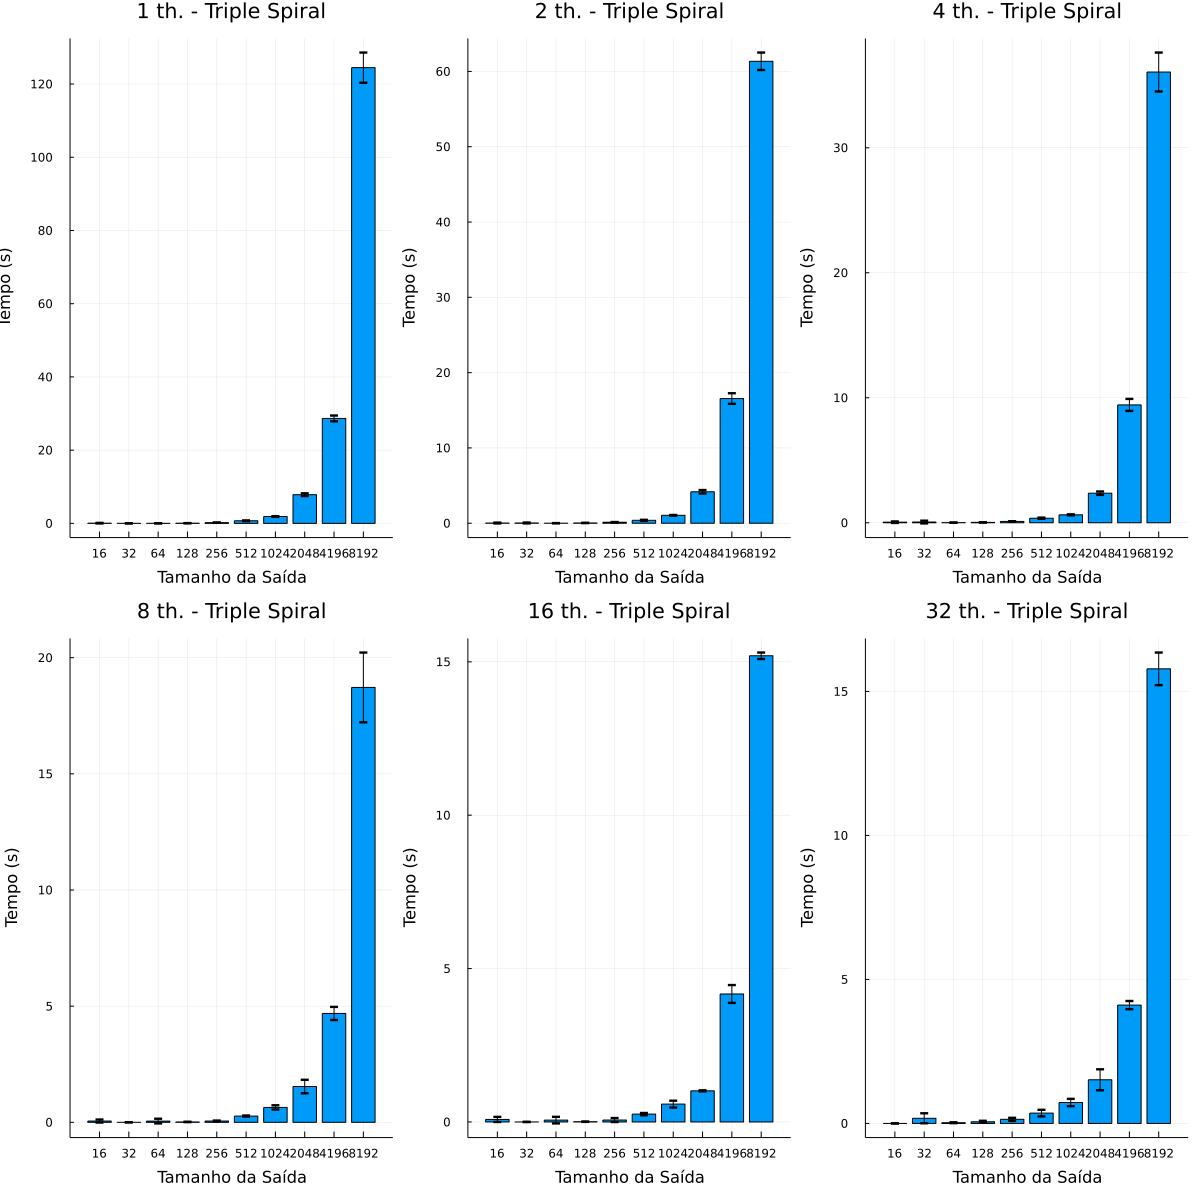

In [25]:
barTitles = legends .* " - Triple Spiral"
plot(p[13], p[14], p[15], p[16], p[17], p[18],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))

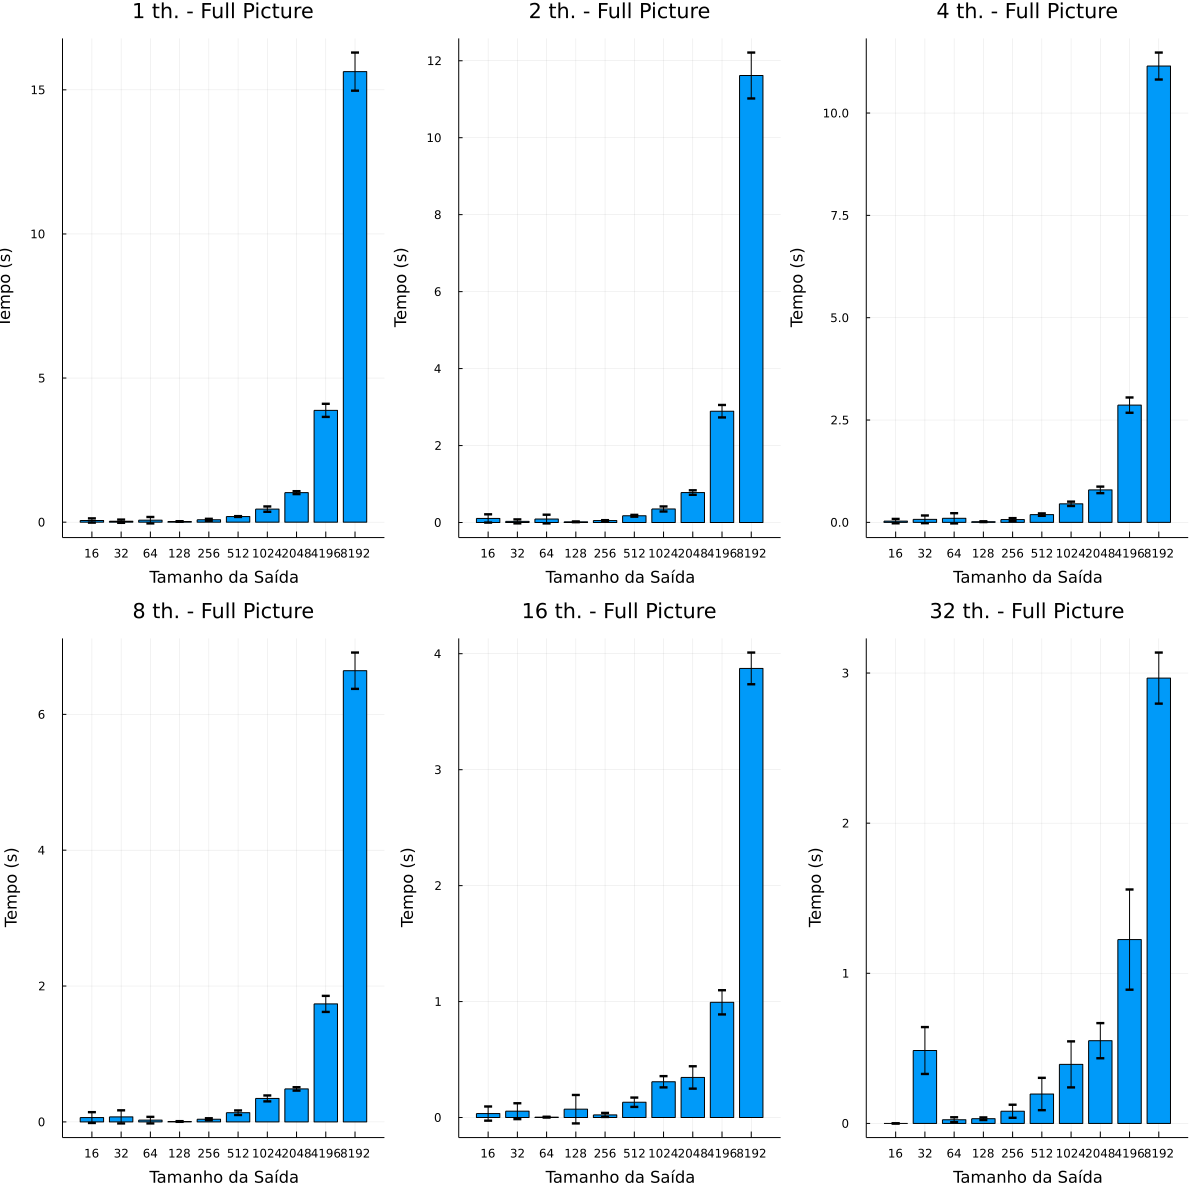

In [26]:
barTitles = legends .* " - Full Picture"
plot(p[19], p[20], p[21], p[22], p[23], p[24],
     titles = barTitles, layout = (2,3))
plot!(size=(1200,1200))